In [101]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

# Main Author: Branden Bulatao

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
# Clips outliers Q1–1.5×IQR and Q3+1.5×IQR
def clip_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip the values
    df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)

    # sns.boxplot(x=f"{feature}", data=df)
    # plt.title(f"{feature} by Valence Group")
    # plt.show()
    return df

def clip_outliers_strict(df, feature):
    lower = df[feature].quantile(0.005)
    upper = df[feature].quantile(0.995)
    df[feature] = df[feature].clip(lower=lower, upper=upper)

    return df

# Check Outlier percentages of each feature
def calculate_outlier_percentage(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df) * 100
    return outlier_percentage

In [ ]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Identify numeric features to scale
numeric_features = [
    # "duration_ms",
    # "popularity",
    # "tempo",
    # "loudness",
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [
    col 
    for col in X.columns 
    if col not in (numeric_features + numeric_high_value_features)
]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# Clip extreme outliers >5%
# threshold = 5
# for col in numeric_features + numeric_high_value_features:
#     percent = calculate_outlier_percentage(X, col)
#     if percent > threshold:
#         X = clip_outliers_strict(X, col)
#         print(f"Clipped {col} (outliers were {percent:.2f}%)")

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", StandardScaler(), numeric_features),
        ("num", "passthrough", numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
final_features = numeric_features + numeric_high_value_features + non_scaled_features
X_processed = pd.DataFrame(X_processed, columns=final_features)
# X_processed = X_processed.apply(pd.to_numeric)  # <-- this line fixes your problem

# Train the code
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

Clipped speechiness (outliers were 11.59%)
Clipped instrumentalness (outliers were 22.15%)
Clipped liveness (outliers were 7.58%)
Clipped loudness (outliers were 5.41%)


In [31]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

0.7727485380116959 
0.7721637426900585 
0.772719298245614 


In [33]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred), "\n")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.772719298245614 

[[14673  3898]
 [ 3875 11754]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     18571
           1       0.75      0.75      0.75     15629

    accuracy                           0.77     34200
   macro avg       0.77      0.77      0.77     34200
weighted avg       0.77      0.77      0.77     34200



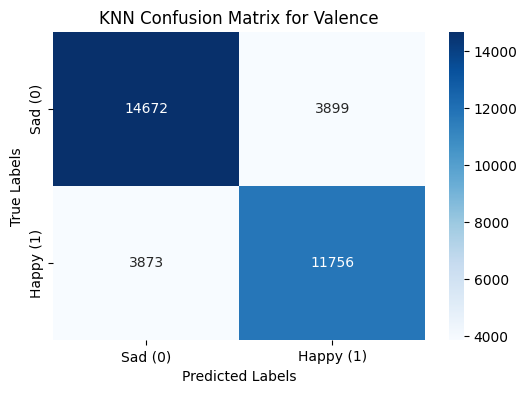

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("KNN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

In [8]:
y_proba = model.predict_proba(X_test)
# y_log_proba = model.predict_log_proba(X_test)

AUC: 0.8524767385466074


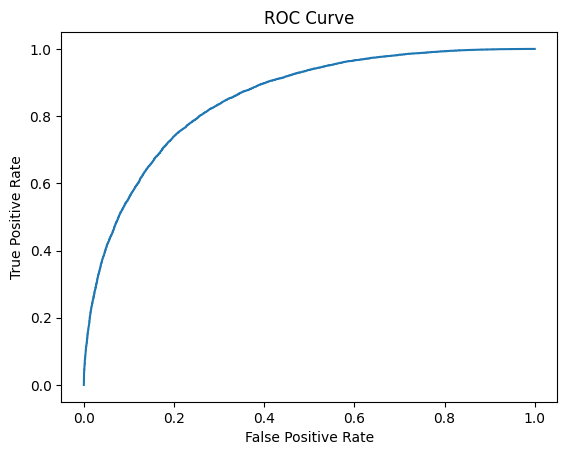

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
print("AUC:", roc_auc_score(y_test, y_proba[:, 1]))


danceability                  6.785592
energy                        4.594012
track_genre_salsa             2.647097
track_genre_rock-n-roll       2.133327
track_genre_classical         2.129155
                                ...   
track_genre_minimal-techno   -2.052154
track_genre_trance           -2.143237
track_genre_dubstep          -2.166945
track_genre_hardstyle        -2.173403
loudness                     -3.289299
Length: 139, dtype: float64


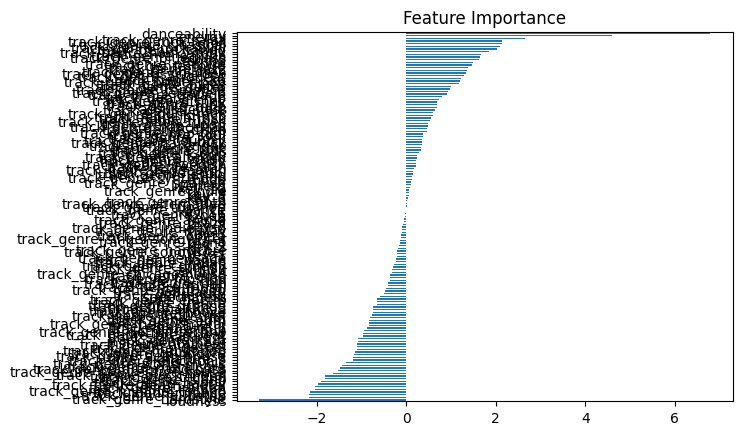

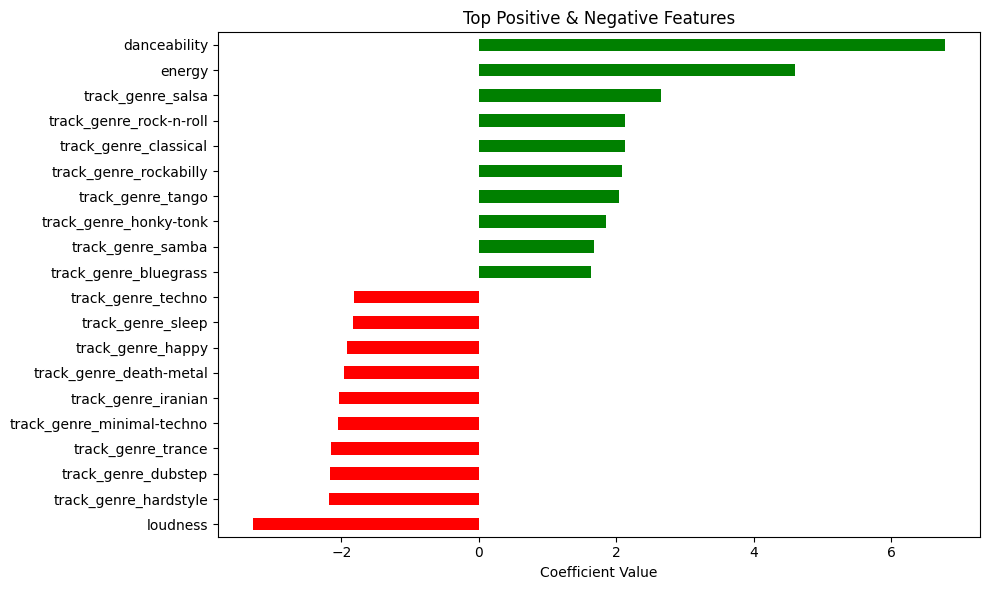

In [20]:
import pandas as pd

coeffs = pd.Series(
    model.coef_[0],
    index= numeric_features + numeric_high_value_features + non_scaled_features,
)
print(coeffs.sort_values(ascending=False))

coeffs.sort_values().plot(kind="barh", title="Feature Importance")

# Get top 10 positive and negative
top_features = pd.concat([coeffs.nlargest(10), coeffs.nsmallest(10)])

# Plot them
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(
    kind="barh", color=["red" if v < 0 else "green" for v in top_features.sort_values()]
)
plt.title("Top Positive & Negative Features")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [13]:
features = numeric_features + numeric_high_value_features + non_scaled_features
print(pd.Series(features).value_counts())

danceability               1
energy                     1
speechiness                1
acousticness               1
instrumentalness           1
                          ..
track_genre_techno         1
track_genre_trance         1
track_genre_trip-hop       1
track_genre_turkish        1
track_genre_world-music    1
Name: count, Length: 139, dtype: int64


['explicit', 'mode', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'track_genre_afrobeat', 'track_genre_alt-rock', 'track_genre_alternative', 'track_genre_ambient', 'track_genre_anime', 'track_genre_black-metal', 'track_genre_bluegrass', 'track_genre_blues', 'track_genre_brazil', 'track_genre_breakbeat', 'track_genre_british', 'track_genre_cantopop', 'track_genre_chicago-house', 'track_genre_children', 'track_genre_chill', 'track_genre_classical', 'track_genre_club', 'track_genre_comedy', 'track_genre_country', 'track_genre_dance', 'track_genre_dancehall', 'track_genre_death-metal', 'track_genre_deep-house', 'track_genre_detroit-techno', 'track_genre_disco', 'track_genre_disney', 'track_genre_drum-and-bass', 'track_genre_dub', 'track_genre_dubstep', 'track_genre_edm', 'track_genre_electro', 'track_genre_electronic', 'track_genre_emo', 'track_genre_folk'

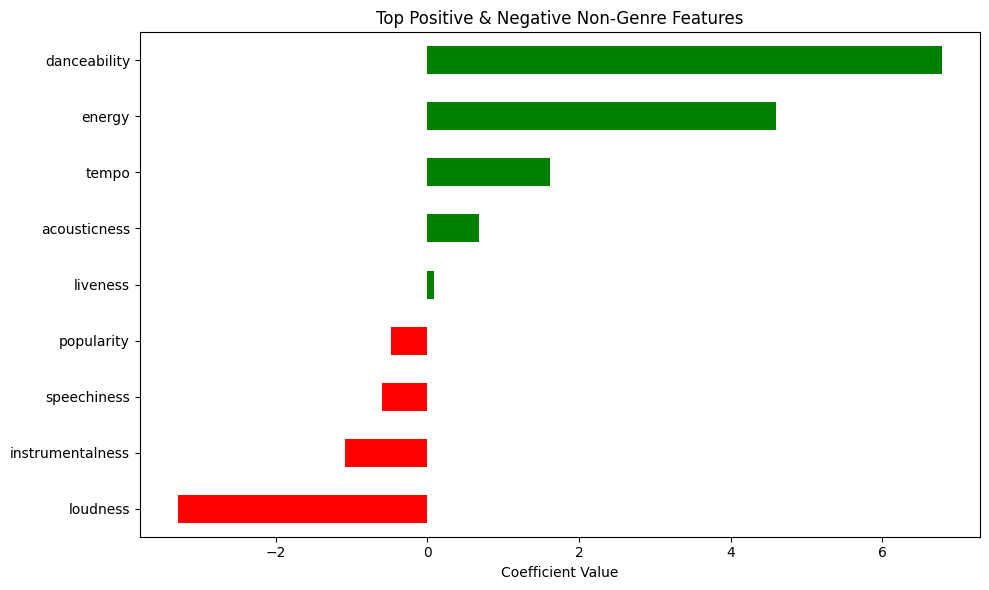

In [18]:
# Remove genre columns from the coefficients
print(non_scaled_features)
non_genre_features = list(set(numeric_features + numeric_high_value_features))
non_genre_features = [f for f in non_genre_features if f in coeffs.index]
non_genre_coeffs = coeffs[non_genre_features]

# non_genre_coeffs = coeffs[numeric_features]
# non_genre_coeffs = coeffs[numeric_features] + coeffs[numeric_high_value_features]

# Get top 10 and bottom 10
top_non_genre = non_genre_coeffs.nlargest(10)

print(top_non_genre)

# Plot
plt.figure(figsize=(10, 6))
top_non_genre.sort_values().plot(
    kind="barh",
    color=["red" if v < 0 else "green" for v in top_non_genre.sort_values()],
)
plt.title("Top Positive & Negative Non-Genre Features")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [21]:
confidences = np.max(y_proba, axis=1)